In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [4]:
image_path="/kaggle/input/face-expression-recognition-dataset/images/train"

train_path="/kaggle/input/face-expression-recognition-dataset/images/train"
valid_path="/kaggle/input/face-expression-recognition-dataset/images/validation"

In [5]:
# Define the list of class names (folders)
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [6]:
class_names

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [7]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,surprise,3205
1,fear,4103
2,angry,3993
3,neutral,4982
4,sad,4938
5,disgust,436
6,happy,7164


In [8]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [10]:
# Load MobileNetV2 with pre-trained weights and exclude the top layers
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Freeze the base model
for layer in mobilenetV2_model.layers:
    layer.trainable = False
    
# Adding custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

In [12]:
# Create the final model
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

In [13]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,100,167 (15.64 MB)

 Trainable params: 1,841,159 (7.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [15]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/901 ━━━━━━━━━━━━━━━━━━━━ 4:51:40 19s/step - accuracy: 0.1250 - loss: 2.5938

I0000 00:00:1723039436.785824     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723039436.825289     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


242/901 ━━━━━━━━━━━━━━━━━━━━ 5:33 506ms/step - accuracy: 0.2878 - loss: 2.0192

W0000 00:00:1723039558.745199     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.3367 - loss: 1.7888

W0000 00:00:1723039868.550789     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 494s 527ms/step - accuracy: 0.3368 - loss: 1.7885 - val_accuracy: 0.4253 - val_loss: 1.5782 - learning_rate: 0.0010


W0000 00:00:1723039911.391087     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 327s 360ms/step - accuracy: 0.4157 - loss: 1.5267 - val_accuracy: 0.4447 - val_loss: 1.4746 - learning_rate: 0.0010
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 320s 352ms/step - accuracy: 0.4280 - loss: 1.4884 - val_accuracy: 0.4125 - val_loss: 1.5594 - learning_rate: 0.0010
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 322s 355ms/step - accuracy: 0.4356 - loss: 1.4647 - val_accuracy: 0.3241 - val_loss: 1.8468 - learning_rate: 0.0010
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 333s 367ms/step - accuracy: 0.4426 - loss: 1.4593 - val_accuracy: 0.4374 - val_loss: 1.4898 - learning_rate: 0.0010
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 339s 374ms/step - accuracy: 0.4562 - loss: 1.4118 - val_accuracy: 0.4754 - val_loss: 1.3905 - learning_rate: 2.0000e-04
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 336s 370ms/step - accuracy: 0.4637 - loss: 1.3989 - val_accuracy: 0.4868 - val_loss: 1.3591 - learning_rate: 2.0000e-04
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 326s 360ms/step 

In [17]:
# Unfreeze the base model and fine-tune
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [18]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
  1/901 ━━━━━━━━━━━━━━━━━━━━ 14:57:59 60s/step - accuracy: 0.2500 - loss: 1.8709

W0000 00:00:1723046267.691242     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


589/901 ━━━━━━━━━━━━━━━━━━━━ 2:09 415ms/step - accuracy: 0.2862 - loss: 1.8524

W0000 00:00:1723046511.579010     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3050 - loss: 1.8020

W0000 00:00:1723046625.744057     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 430s 411ms/step - accuracy: 0.3051 - loss: 1.8019 - val_accuracy: 0.4183 - val_loss: 1.5366 - learning_rate: 1.0000e-05
Epoch 2/10


W0000 00:00:1723046637.854648     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 334s 368ms/step - accuracy: 0.4279 - loss: 1.4936 - val_accuracy: 0.4181 - val_loss: 1.5063 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 331s 364ms/step - accuracy: 0.4784 - loss: 1.3617 - val_accuracy: 0.4474 - val_loss: 1.4396 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 331s 364ms/step - accuracy: 0.5137 - loss: 1.2945 - val_accuracy: 0.4724 - val_loss: 1.3804 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 336s 370ms/step - accuracy: 0.5301 - loss: 1.2435 - val_accuracy: 0.5089 - val_loss: 1.3077 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 344s 380ms/step - accuracy: 0.5422 - loss: 1.2016 - val_accuracy: 0.5273 - val_loss: 1.2536 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 341s 376ms/step - accuracy: 0.5622 - loss: 1.1571 - val_accuracy: 0.5654 - val_loss: 1.1542 - learning_rate: 1.0000e-05
Epoch 8/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 336s 370ms/

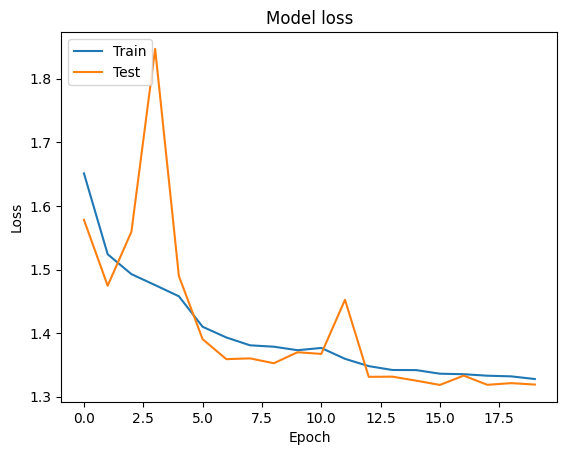

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

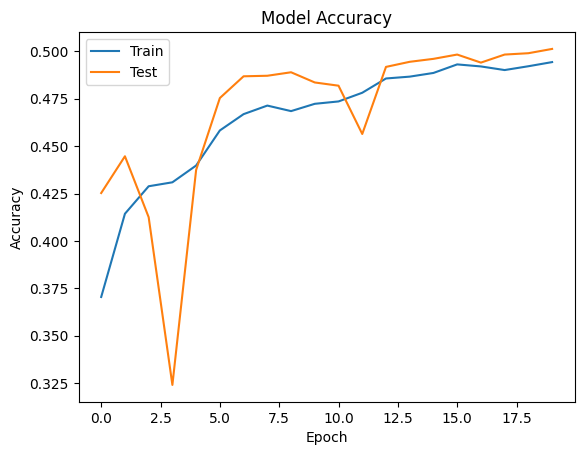

In [21]:
# Plot training & validation loss values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
true_classes = validation_generator.classes
predicted_classes = np.argmax(model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size))), axis=1)
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

  6/221 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

W0000 00:00:1723049865.548958     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step


W0000 00:00:1723049878.924451     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


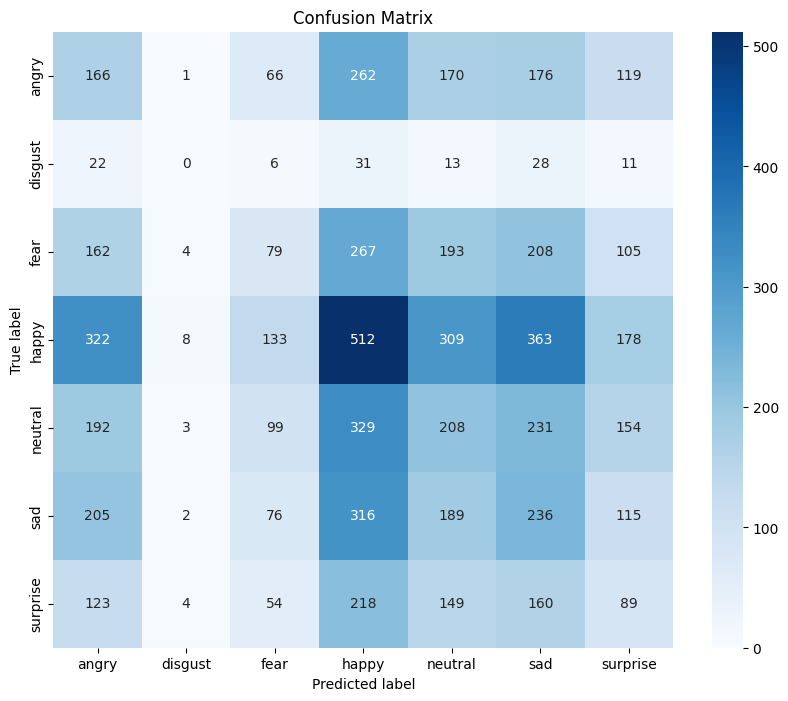

In [28]:
# Plotting confusion matrix with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
#classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.17      0.15       960
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.08      0.10      1018
       happy       0.26      0.28      0.27      1825
     neutral       0.17      0.17      0.17      1216
         sad       0.17      0.21      0.19      1139
    surprise       0.12      0.11      0.11       797

    accuracy                           0.18      7066
   macro avg       0.14      0.15      0.14      7066
weighted avg       0.18      0.18      0.18      7066



In [22]:
model.save('emotion_detection_model.h5')